# Sales & Demand Forecasting Analysis

## Objective
Predict future sales for a retail business using historical transaction data. This notebook covers:
1. Data Cleaning & Exploration
2. Feature Engineering (Trends, Seasonality)
3. Forecasting Model (Random Forest)
4. Evaluation & Visualization

## 1. Setup & Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

# Load Data
df = pd.read_csv('data/retail_sales_simulated.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Store_ID,Product_ID,Units_Sold,Revenue
0,2024-01-01,Store_1,Product_A,45,3706.89
1,2024-01-01,Store_1,Product_B,32,1039.41
2,2024-01-01,Store_1,Product_C,27,1260.81
3,2024-01-01,Store_1,Product_D,44,3372.42
4,2024-01-01,Store_1,Product_E,31,2947.61


## 2. Exploratory Data Analysis (EDA)
Understanding sales trends over time.

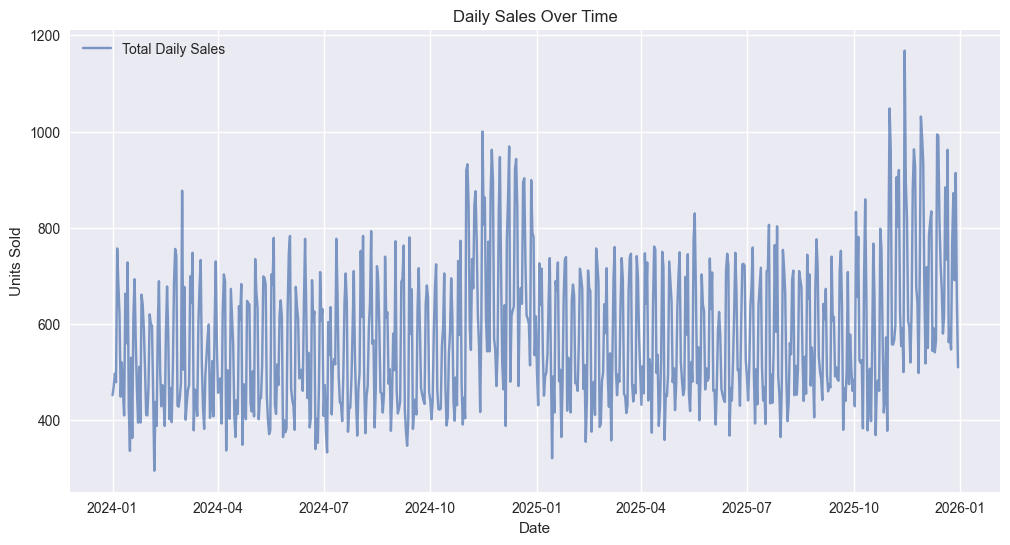

In [14]:
# Aggregate daily sales
daily_sales = df.groupby('Date')['Units_Sold'].sum().reset_index()

# Plot Daily Sales
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['Date'], daily_sales['Units_Sold'], label='Total Daily Sales', alpha=0.7)
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

## 3. Feature Engineering
Machine Learning models need numerical inputs. We'll create features from the Date column.

In [15]:
# Extract Date Components
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfMonth'] = df['Date'].dt.day
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Encode Categorical Variables
df = pd.get_dummies(df, columns=['Store_ID', 'Product_ID'], drop_first=True, dtype=int)

print("Features created.")
df.head()

Features created.


,Date,Units_Sold,Revenue,DayOfWeek,Month,Year,DayOfMonth,IsWeekend,Store_ID_Store_2,Store_ID_Store_3,Product_ID_Product_B,Product_ID_Product_C,Product_ID_Product_D,Product_ID_Product_E
0,2024-01-01,45,3706.89,0,1,2024,1,0,0,0,0,0,0,0
1,2024-01-01,32,1039.41,0,1,2024,1,0,0,0,1,0,0,0
2,2024-01-01,27,1260.81,0,1,2024,1,0,0,0,0,1,0,0
3,2024-01-01,44,3372.42,0,1,2024,1,0,0,0,0,0,1,0
4,2024-01-01,31,2947.61,0,1,2024,1,0,0,0,0,0,0,1


## 4. Modeling (Random Forest Regressor)
We will split the data by time (Train on older data, Test on newer data) to simulate real forecasting.

In [16]:
# Sort by Date
df = df.sort_values('Date')

# Define Features (X) and Target (y)
features = [col for col in df.columns if col not in ['Date', 'Units_Sold', 'Revenue']]
X = df[features]
y = df['Units_Sold']

# Time-Based Split (80% Train, 20% Test)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model Trained.")

Model Trained.


## 5. Evaluation
Comparing Actual vs Predicted sales on the test set.

Mean Absolute Error (MAE): 16.25
Root Mean Squared Error (RMSE): 19.74


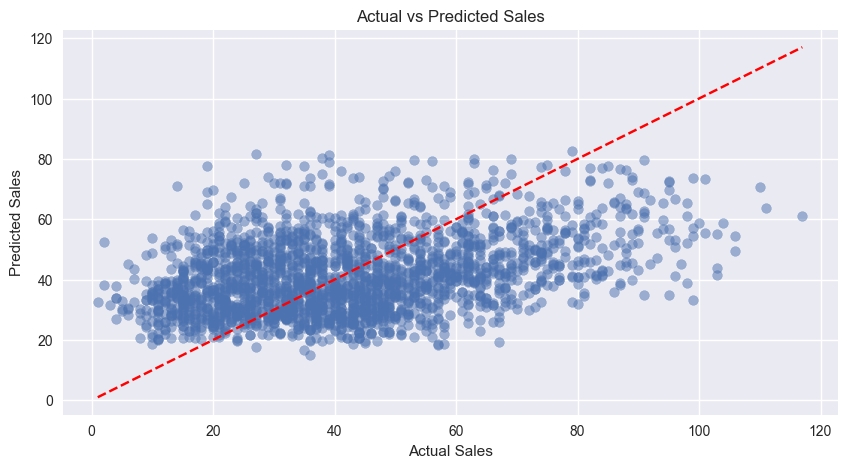

In [17]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

## 6. Future Forecast
Generating sales predictions for next month.

In [18]:
# Create Future Dates (Next 30 Days)
last_date = df['Date'].max()
future_dates = [last_date + timedelta(days=x) for x in range(1, 31)]

# Placeholder for future data
future_data = []

# Generate features for all Stores/Products for future dates
# Note: In a real app, we would loop through all unique store/product combos.
# Here we simplify and predict for 'Store_1' and 'Product_A' as an example trend.

sample_store_cols = [c for c in X.columns if 'Store_ID' in c]
sample_prod_cols = [c for c in X.columns if 'Product_ID' in c]

for date in future_dates:
    row = {}
    row['DayOfWeek'] = date.weekday()
    row['Month'] = date.month
    row['Year'] = date.year
    row['DayOfMonth'] = date.day
    row['IsWeekend'] = 1 if date.weekday() >= 4 else 0
    
    # Set Dummy Variables to 0 (Baseline: Store_1, Product_A is usually represented when all dummies are 0)
    for c in sample_store_cols: row[c] = 0 
    for c in sample_prod_cols: row[c] = 0
    
    future_data.append(row)

future_df = pd.DataFrame(future_data)

# Predict
future_sales = model.predict(future_df[features])

# Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_sales, marker='o', linestyle='-', color='green')
plt.title('Projected Sales for Store 1, Product A (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Predicted Units')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

NameError: name 'timedelta' is not defined